# A Computational Theory of Child Overextension - Demo

### By Renato Ferreira Pinto Junior

This notebook demonstrates the multimodal semantic space and computational framework of child overextension presented in the paper:

Ferreira Pinto, R., Jr., & Xu, Y. (2019). <em>A Computational Theory of Child Overextension</em>. Manuscript submitted for publication.

We provide three computational demonstrations:

* Word frequencies in child-directed speech, as a component of cognitive effort in overextension
* Multimodal semantic space of concepts and retrieval of closest concepts in semantic space
* Model predictions of child overextension for probe concepts, considering semantic relations and cognitive effort

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
import seaborn as sn
from pprint import pprint

%matplotlib inline
sn.set_context('paper', font_scale=1.5)

## Load data sources

This section loads the child vocabulary, list of all possible concepts (referents), and associated semantic features.

In [2]:
prod_vocab = pd.read_csv('filtered_prod_vocab.csv')  # productive vocabulary
full_vocab = pd.read_csv('filtered_lexicon.csv')     # all words (productive vocabulary and referents)
freq_data  = pd.read_csv('prod_vocab_rel_freqs.csv') # relative frequencies
dists      = np.load('dist_matrix_square.npy')       # all distances in multimodal space: tensor of C x C x 3, where C = number of concepts
dists_overextension = np.load('dist_matrix.npy')     # subset of distances relevant for overextension: only vocabulary in one dimension, all concepts in the other

In [3]:
# Build frequency dictionary.
freq = {}
for _, row in freq_data.iterrows():
    freq[row['wordnet_synset']] = row['rel_freq']

In [4]:
# Function to look up words in vocabulary.
def lookup_word(word, vocab):
    for i, row in vocab.iterrows():
        synset = wn.synset(row['wordnet_synset'])
        lemmas = [l.name() for l in synset.lemmas()]
        if word in lemmas:
            return i
    raise ValueError("'%s' not in vocabulary" % word)

# Function to look up word frequency.
def word_frequency(word):
    i = lookup_word(word, full_vocab)
    wordnet = full_vocab.loc[i, 'wordnet_synset']
    return freq[wordnet]

## Word frequency in child-directed speech

Here, we exemplify the differences in word frequency in child-directed speech within one domain (animals).

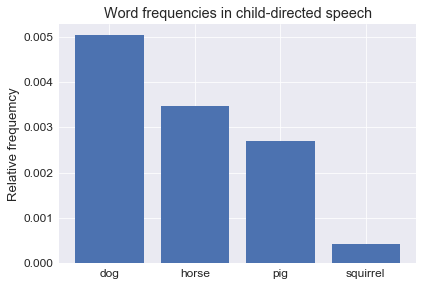

In [5]:
test_words_freq = ['dog', 'horse', 'pig', 'squirrel']
freqs      = [word_frequency(w) for w in test_words_freq]

plt.bar(range(len(test_words_freq)), freqs, tick_label=test_words_freq)
plt.title('Word frequencies in child-directed speech')
plt.ylabel('Relative frequemcy')

Note how "squirrel" is much less frequent than "dog", for example, suggesting why "dog",
an easier word for young children, can be overextended to squirrels in child speech.

## Exploring multimodal space

We start by showing how different semantic relations in the multimodal space can collaborate to explain diverse conceptual leaps in overextension strategies.

First, we define the sensitivity parameters (kernel widths) for the different slices of the multimodal space as presented in the paper. You can experiment with changing these parameters and re-evaluating the analyses to see how the model responds as it becomes more or less sensitive to semantic distance (smaller and larger kernel width, respectively).

In [6]:
kernel_width_multimodal = 0.43577904 # from paper, trained on production data
kernel_width_cat        = 0.29509603
kernel_width_vis        = 0.19985287
kernel_width_pred       = 0.35533736

In [7]:
# Plot confusion matrix for any slice of multimodal space.
def plot_confusion_matrix(test_words_multimodal, dists, kernel_width, title, ax):
    word_ids = [lookup_word(w, full_vocab) for w in test_words_multimodal]
    dist     = dists[word_ids,:,:][:,word_ids,:]
    dist     = np.linalg.norm(dist, ord=2, axis=2)
    sim      = np.exp(-np.square(dist) / kernel_width)
    df       = pd.DataFrame(sim, index=test_words_multimodal, columns=test_words_multimodal)
    sn.heatmap(df, annot=True, ax=ax, vmin=0, vmax=1)
    ax.set_title(title)

def plot_all_matrices(test_words_multimodal):
    fig, axes = plt.subplots(2,2, figsize=(13,11))
    plot_confusion_matrix(test_words_multimodal, dists,             kernel_width_multimodal, "Multimodal space",      axes[0,0])
    plot_confusion_matrix(test_words_multimodal, dists[:,:,0,None], kernel_width_cat,        "Categorical space",     axes[0,1])
    plot_confusion_matrix(test_words_multimodal, dists[:,:,1,None], kernel_width_vis,        "Visual space",          axes[1,0])
    plot_confusion_matrix(test_words_multimodal, dists[:,:,2,None], kernel_width_pred,       "Predicate-based space", axes[1,1])

Here, we show the distances in the full multimodal space, and broken down by individual semantic relation, for three concepts: apple, egg, and chicken. You can experiment running this section with different concepts to see how they relate in semantic space.

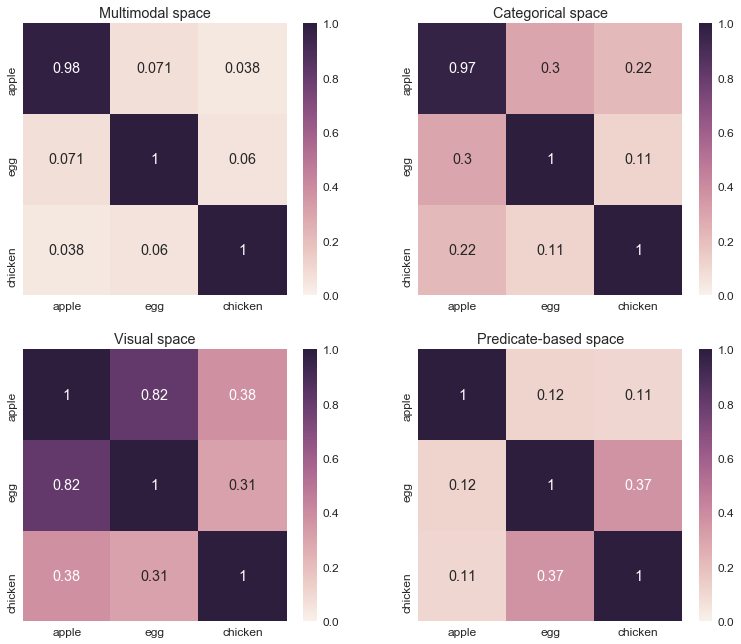

In [8]:
plot_all_matrices(['apple', 'egg', 'chicken'])

We can see that different semantic relations show complementary information about how these concepts relate to each other. For example, apple and egg relate most closely in visual space, since both are round objects. Due to this relation, they are also the closest pair of distinct concepts in multimodal space. The second pair of notice, chicken and egg, also display relative similarity due to their closeness in predicate space.

### Fine-grained retrieval of semantically-related concepts

We can also retrieve, given a query concept, the concepts in our repertoire that most closely relate to it in the full multimodal space. The following analysis implements this idea.

In [9]:
def closest_in_space(word, dists, top_k=7):
    word_id = lookup_word(word, full_vocab)
    dist = dists[:, word_id, :].sum(axis=1)
    ids  = np.argsort(dist)
    top  = list(ids[:top_k])
    if word_id in top: top.remove(word_id)
    res  = [full_vocab.loc[t, 'wordnet_synset'] for t in top]
    res  = [wn.synset(s).lemmas()[0].name() for s in res]
    return res

In [10]:
def print_closest_in_space(word):
    print('----------- Word: %s -----------' % word)
    print('Multimodal:\t\t{}'.format(
        closest_in_space(word, dists)))    
    print('Categorical:\t\t{}'.format(
        closest_in_space(word, dists[:,:,0,None])))
    print('Visual:\t\t\t{}'.format(
        closest_in_space(word, dists[:,:,1,None])))
    print('Predicate-based:\t{}'.format(
        closest_in_space(word, dists[:,:,2,None])))

The following examples show retrieval results for four concepts: apple, door, dog, and ball. In each case, we show retrievals from the multimodal space, as well as from each individual semantic relation. Notice how these dimensions contribute complementary retrievals toward the multimodal query, which displays a variety of concepts related to the query via diverse relations.

In [11]:
print_closest_in_space('apple')

----------- Word: apple -----------
Multimodal:		['pear', 'fruit', 'grape', 'plum', 'orange', 'peach']
Categorical:		['pear', 'fruit', 'plum', 'nut', 'melon', 'peach']
Visual:			['peach', 'plum', 'pear', 'vitamin', 'fruit', 'melon']
Predicate-based:	['orange', 'pear', 'fruit', 'grape', 'juice', 'banana']


In [12]:
print_closest_in_space('door')

----------- Word: door -----------
Multimodal:		['window', 'porch', 'garage', 'cupboard', 'basement', 'shutter']
Categorical:		['porch', 'dwelling', 'basement', 'house', 'school', 'tooth']
Visual:			['window', 'garage', 'basement', 'stairs', 'school', 'shutter']
Predicate-based:	['window', 'key', 'cupboard', 'shutter', 'porch', 'rear']


In [13]:
print_closest_in_space('dog')

----------- Word: dog -----------
Multimodal:		['puppy', 'animal', 'cat', 'coyote', 'wolf', 'bear']
Categorical:		['fox', 'wolf', 'hyena', 'puppy', 'coyote', 'bear']
Visual:			['puppy', 'animal', 'goat', 'menagerie', 'head', 'horse']
Predicate-based:	['puppy', 'cat', 'hand', 'kitten', 'coyote', 'kitty']


In [14]:
print_closest_in_space('ball')

----------- Word: ball -----------
Multimodal:		['game', 'marble', 'skate', 'basket', 'toy', 'balloon']
Categorical:		['marble', 'game', 'puzzle', 'telephone', 'skate', 'camera']
Visual:			['game', 'chewing_gum', 'egg', 'ellipse', 'light', 'circle']
Predicate-based:	['bat', 'game', 'basket', 'rocket', 'balloon', 'balloon']


## Model predictions of overextension

Here, we apply the predictive model of child overextension (in production) by jointly considering cognitive effort encoded as word frequency (prior) and semantic relations (likelihood) in a probabilistic model.

In [15]:
word_freqs = np.array([freq[w] for w in prod_vocab['wordnet_synset'].values])

def predict_production(referent, dists, kernel_width, top_k=7):
    word_id = lookup_word(referent, full_vocab)
    dist = dists[:, word_id, :]
    dist = np.linalg.norm(dist, ord=2, axis=1)
    sim  = np.exp(-np.square(dist) / kernel_width)
    prob = sim * word_freqs
    ids  = np.argsort(-prob)
    top  = ids[:top_k]
    res  = [prod_vocab.loc[t, 'wordnet_synset'] for t in top]
    res  = [wn.synset(s).lemmas()[0].name() for s in res]
    return res

In [16]:
def print_all_predictions(word):
    print('----------- Referent: %s -----------' % word)
    print('Multimodal:\t\t{}'.format(
        predict_production(word, dists_overextension, kernel_width_multimodal)))    
    print('Categorical:\t\t{}'.format(
        predict_production(word, dists_overextension[:,:,0,None], kernel_width_cat)))
    print('Visual:\t\t\t{}'.format(
        predict_production(word, dists_overextension[:,:,1,None], kernel_width_vis)))
    print('Predicate-based:\t{}'.format(
        predict_production(word, dists_overextension[:,:,2,None], kernel_width_pred)))

The following examples show top 7 model productions for a variery of query concepts; you can try running these queries with other concepts as well.

Notice how the top multimodal productions draw from different semantic relations, such as by relating <em>ball</em> to baloon and grape, <em>dog</em> to squirrel, or <em>foot</em> to shoe.

In [17]:
print_all_predictions('squirrel')

----------- Referent: squirrel -----------
Multimodal:		['animal', 'baby', 'kitten', 'bunny', 'kitty', 'dog', 'cat']
Categorical:		['baby', 'animal', 'dog', 'son', 'kitty', 'book', 'bunny']
Visual:			['baby', 'animal', 'book', 'bunny', 'kitten', 'ball', 'kitty']
Predicate-based:	['baby', 'animal', 'kitten', 'hand', 'book', 'dog', 'kitty']


In [18]:
print_all_predictions('grape')

----------- Referent: grape -----------
Multimodal:		['apple', 'juice', 'grape', 'baby', 'orange', 'cheese', 'ball']
Categorical:		['baby', 'book', 'ball', 'apple', 'cheese', 'toy', 'son']
Visual:			['baby', 'ball', 'toy', 'egg', 'book', 'son', 'juice']
Predicate-based:	['juice', 'baby', 'apple', 'book', 'grape', 'ball', 'food']


In [19]:
print_all_predictions('balloon')

----------- Referent: balloon -----------
Multimodal:		['ball', 'balloon', 'toy', 'baby', 'book', 'car', 'box']
Categorical:		['car', 'book', 'ball', 'baby', 'toy', 'box', 'shoe']
Visual:			['ball', 'baby', 'toy', 'book', 'juice', 'egg', 'chair']
Predicate-based:	['ball', 'baby', 'toy', 'balloon', 'book', 'son', 'juice']


In [20]:
print_all_predictions('goose')

----------- Referent: goose -----------
Multimodal:		['duck', 'bird', 'goose', 'baby', 'animal', 'chicken', 'dog']
Categorical:		['baby', 'duck', 'animal', 'son', 'book', 'bird', 'dog']
Visual:			['baby', 'duck', 'ball', 'animal', 'toy', 'book', 'water']
Predicate-based:	['duck', 'baby', 'egg', 'book', 'ball', 'ma', 'bird']


In [21]:
print_all_predictions('dome')

----------- Referent: dome -----------
Multimodal:		['ball', 'baby', 'book', 'hat', 'house', 'dwelling', 'box']
Categorical:		['book', 'baby', 'shoe', 'ball', 'toy', 'car', 'house']
Visual:			['baby', 'ball', 'book', 'house', 'dwelling', 'animal', 'toy']
Predicate-based:	['baby', 'ball', 'book', 'box', 'car', 'hat', 'house']


In [22]:
print_all_predictions('shoe')

----------- Referent: shoe -----------
Multimodal:		['shoe', 'baby', 'box', 'ball', 'book', 'sock', 'toy']
Categorical:		['book', 'shoe', 'baby', 'ball', 'toy', 'car', 'house']
Visual:			['baby', 'shoe', 'ball', 'book', 'toy', 'box', 'chair']
Predicate-based:	['shoe', 'foot', 'baby', 'book', 'box', 'ball', 'sock']
